In [17]:
# Useful starting lines
import pickle
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
%load_ext autoreload
%autoreload 2
from IPython import display
from proj1_helpers import *
from implementations import *
from features import *
from cross_validation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Evaluate a model

def accuracy(y, y_pred):
    """ Compute accuracy. """
    right = np.sum(y_pred == y)
    wrong = len(y_pred) - right
    accuracy = right / len(y)

    #print("Good prediction: %i/%i (%.3f%%)\nWrong prediction: %i/%i (%.3f%%)" %
        #(right, len(y), 100.0 * accuracy, wrong, len(y), 100.0 * (1-accuracy)))
    
    return accuracy

In [ ]:
# Load the whole data

# Pickle dataset for fast reload
y_train, x_train, ids_train, headers = load_csv_data('data/train.csv')
y_test, x_test, ids_test, headers_test = load_csv_data('data/test.csv')
pickle.dump((y_train, x_train, ids_train, headers), open('train.pickle', 'wb'))
pickle.dump((y_test, x_test, ids_test, headers_test), open('test.pickle', 'wb'))



In [4]:
# Load dataset using pickle
def reload_dataset():
    global y_train, x_train, ids_train, headers, y_test, x_test, ids_test, headers_test
    y_train, x_train, ids_train, headers = pickle.load(open('train.pickle', 'rb'))
    y_test, x_test, ids_test, headers_test = pickle.load(open('test.pickle', 'rb'))

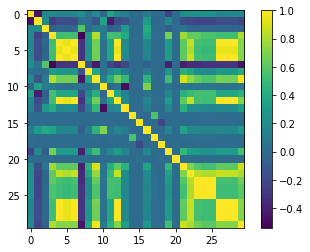

In [4]:
# Correlation analysis

correlation_matrix = np.corrcoef(x_train.T)

plt.imshow(correlation_matrix)
plt.colorbar()

In [5]:
def build_k_indices(y, k_fold, seed=1):
    """build k indices for k-fold."""
    totalLength = y.shape[0]
    intervalLength = int(totalLength / k_fold) # Length of an internval
    np.random.seed()
    indices = np.random.permutation(totalLength)
    k_indices = [indices[k * intervalLength: (k + 1) * intervalLength] for k in range(k_fold)]
    #print(k_indices)
    return np.array(k_indices)

In [6]:
def processing(x, deg, jet_mod=False, jet_num=0, mean=None, std=None):
    long_tails=[0, 1, 2, 3, 5, 8, 9, 10, 13, 16, 19, 21, 23, 26, 29]
    # Get the valid and invalid values (-999)
    missing_mask = x == -999
    correct_mask = x != -999
    
    # Log transform all the long tails
    for i in long_tails:
        # Only the valid values
        x[correct_mask[:,i],i] = np.log(1 + x[correct_mask[:,i],i])

    # Difference between angles
    angle = [15, 18, 20]
    diff01 = np.abs(x[:,angle[0]] - x[:,angle[1]]).reshape((len(x), 1))
    diff02 = np.abs(x[:,angle[0]] - x[:,angle[2]]).reshape((len(x), 1))
    diff12 = np.abs(x[:,angle[1]] - x[:,angle[2]]).reshape((len(x), 1))
    
    x = np.hstack((x, diff01, diff02, diff12))
            
    # Exclude some invalid variables depending of the jet_num
    if jet_mod:
        features_excluded = [[4, 5, 6, 12, 15,18,20, 22, 23, 24, 25, 26, 27, 28], [4, 5, 6, 12, 15,18,20, 22,25, 26, 27, 28], [15,18,20,25,28], [15,18,20,25,28]]
        excepted = np.setdiff1d(np.arange(x.shape[1]), features_excluded[jet_num])
        x = x[:,excepted]
    #print("Remaining number of variables: " + str(len(x[0])))
    

    # Standardize
    x, mean, std = standardize(x, mean, std)

    # Build polynomial features
    x = build_poly(x, deg)
    
    return x, mean, std

def show_x(x):
    for i in range(len(x[0])):
        array = x[:,i]
        plt.hist(array, 250)
        plt.title("Variable %i: %s"%(i, headers[i+2]))
        plt.show()
    return x

In [ ]:
# Load dataset
reload_dataset()

# Parameters
ratio = 0.8
deg = 1
k_fold = 10

accuracies = []
numbers = []


mon_fichier = open("fichier.txt", "w") # Argh j'ai tout écrasé !



# We train a classifier for each "jet"
for i in range(2,-1,-1):
    print("Jet: " + str(i))
    best = 0
    best_lambda = 0
    best_degree = 0
    best_gamma = 0
    # Select the corresponding rows
    jet_mask_train = x_train[:,22] == i
    jet_mask_test = x_test[:,22] == i
    if i == 2 :
        # 2 and 3 are treated the same way
        jet_mask_train = np.asarray(x_train[:,22]==i) + np.asarray(x_train[:,22]==3) 
        jet_mask_test = np.asarray(x_test[:,22]==i) + np.asarray(x_test[:,22]==3) 
        
    x_jet_train, x_jet_test = x_train[jet_mask_train], x_test[jet_mask_test]
    y_jet_train, y_jet_test = y_train[jet_mask_train], y_test[jet_mask_test]
    
    k_indices = build_k_indices(y_jet_train, k_fold)

    for deg in range(1,20,1):
        print("Degré : " + str(deg))
        
        for lambda_ in np.logspace(-11,-2,9):
            print("Lambda : " + str(lambda_))
            
            for gamma in np.logspace(-8,0,9):
            
    #             if i ==0:
    #                 deg=10
    #                 lambda_=10**(-7)
    #             elif i ==1:
    #                 deg=10
    #                 lambda_=10**(-10)
    #             elif i ==2:
    #                 deg=9
    #                 lambda_=10**(-8)
    #             elif i ==3:
    #                 deg=12
    #                 lambda_=4*10**(-7)

                accuracies = []
                numbers = []

                # Process features
                x_jet_train_processed, mean, std = processing(x_jet_train, deg, True, i)
    #             x_jet_test_processed, _, _ = processing(x_jet_test, deg, True, i, mean, std)

                # Split data (create a validation set)
                #x_jet_train_current, y_jet_train_current, x_jet_valid_current, y_jet_valid_current = split_data(x_jet_train_current, y_jet_train, ratio)

                for k in range(k_fold):
                    new_accuracy = cross_validation(y_jet_train, x_jet_train_processed, k_indices, k, lambda_, gamma)
                    accuracies.append(new_accuracy)

                # Training
                #w,loss =least_squares(y_jet_train, x_jet_train)
                #w, loss = least_squares_SGD(y_jet_train, x_jet_train, np.zeros(x_jet_train.shape[1]), 200, 3e-2)
                w, loss = ridge_regression(y_jet_train,x_jet_train_processed, lambda_)
                #w, loss = reg_logistic_regression_SGD((y_train2 == 1).astype(float), train_processed_poly, 1e-5,
                #	np.zeros(train_processed_poly.shape[1]), 2000, 1e-7)
                #print("Loss = %f"%(loss))

                # Prediction
                #y_jet_valid_pred = predict_labels(w, x_jet_valid)
    #             y_jet_test_pred = predict_labels(w, x_jet_test_processed)

                # Evaluation
                new_accuracy = np.asarray(accuracies).mean()
                if new_accuracy>best:
                    best=new_accuracy
                    print("New best accuracy !!!!!!!!!!!!!!! Score : " + str(new_accuracy) +" Lambda : " +str(lambda_)+" Gamma : " +str(gamma) + " Degre : "+str(deg) + " Jet : " + str(i) )
                    mon_fichier.write("New best accuracy !!!!!!!!!!!!!!! Score : " + str(new_accuracy) +" Lambda : " +str(lambda_)+" Gamma : " +str(gamma) + " Degre : "+str(deg) + " Jet : " + str(i)  )
                    best_lambda = lambda_
                    best_degree = deg
                accuracies.append(new_accuracy)
                print("Tested but not opti : " + str(new_accuracy))
    #             #numbers.append(len(y_jet_valid))
    #             create_csv_submission(ids_test[jet_mask_test], y_jet_test_pred, "submission" + str(i))
    #             break
    #         break
    #    break

mon_fichier.close()
        #print('\nGlobal accuracy:', np.dot(accuracies, numbers) / np.sum(numbers))

Jet: 2
Degré : 1
Lambda : 1e-11
New best accuracy !!!!!!!!!!!!!!! Score : 0.713744141163 Lambda : 1e-11 Gamma : 1e-08 Degre : 1 Jet : 2
Tested but not opti : 0.713744141163
New best accuracy !!!!!!!!!!!!!!! Score : 0.717231872071 Lambda : 1e-11 Gamma : 1e-07 Degre : 1 Jet : 2
Tested but not opti : 0.717231872071
New best accuracy !!!!!!!!!!!!!!! Score : 0.736931348222 Lambda : 1e-11 Gamma : 1e-06 Degre : 1 Jet : 2
Tested but not opti : 0.736931348222
New best accuracy !!!!!!!!!!!!!!! Score : 0.773090708575 Lambda : 1e-11 Gamma : 1e-05 Degre : 1 Jet : 2
Tested but not opti : 0.773090708575
New best accuracy !!!!!!!!!!!!!!! Score : 0.809360352909 Lambda : 1e-11 Gamma : 0.0001 Degre : 1 Jet : 2
Tested but not opti : 0.809360352909
New best accuracy !!!!!!!!!!!!!!! Score : 0.814157706093 Lambda : 1e-11 Gamma : 0.001 Degre : 1 Jet : 2
Tested but not opti : 0.814157706093


/Users/robinclerc/Dropbox/EPFL/Machine learning/ML_course/projects/project1/machine_learning_projet1/implementations.py:105: RuntimeWarning: divide by zero encountered in log
  return -(np.dot(y.T, np.log(p)) + np.dot((1-y).T, np.log(1-p))) + lambda_*np.dot(w.T, w)
/Users/robinclerc/Dropbox/EPFL/Machine learning/ML_course/projects/project1/machine_learning_projet1/implementations.py:80: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))


Tested but not opti : 0.757609594706
Tested but not opti : 0.751075268817
Tested but not opti : 0.745864350703
Lambda : 1.33352143216e-10
Tested but not opti : 0.710697546181
Tested but not opti : 0.714736696995
Tested but not opti : 0.734201819686
Tested but not opti : 0.768582850841
Tested but not opti : 0.806575682382
Tested but not opti : 0.810256410256
Tested but not opti : 0.754025365316
Tested but not opti : 0.744306589468
Tested but not opti : 0.761276537083
Lambda : 1.77827941004e-09
Tested but not opti : 0.711276537083
Tested but not opti : 0.714474772539
Tested but not opti : 0.733677970775
Tested but not opti : 0.767838433967
Tested but not opti : 0.8052936311
Tested but not opti : 0.810904328646
Tested but not opti : 0.761304108078
Tested but not opti : 0.750096498484
Tested but not opti : 0.744251447477
Lambda : 2.37137370566e-08
Tested but not opti : 0.710959470637
Tested but not opti : 0.714612627516
Tested but not opti : 0.733388475324
Tested but not opti : 0.766735594

In [ ]:
for i in range(3,-1,-1):
    print(i)

In [7]:
print(np.square(np.asarray([1,2,3])))

[1 4 9]


In [16]:
print(headers)

['Id' 'Prediction' 'DER_mass_MMC' 'DER_mass_transverse_met_lep'
 'DER_mass_vis' 'DER_pt_h' 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet'
 'DER_prodeta_jet_jet' 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt'
 'DER_pt_ratio_lep_tau' 'DER_met_phi_centrality' 'DER_lep_eta_centrality'
 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta'
 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_num'
 'PRI_jet_leading_pt' 'PRI_jet_leading_eta' 'PRI_jet_leading_phi'
 'PRI_jet_subleading_pt' 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi'
 'PRI_jet_all_pt']
